<a href="https://colab.research.google.com/github/Playback89/HunyuanPortrait/blob/main/Wan2_1_VACE_Img2Img_PoseTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wan2.1 VACE Image to Image Pose Transfer with Face Correction (Experimental)**

- You can use the dwpose controlnet by disabling both the canny and depth controlnets. Note that dwpose uses more VRAM which can result in crashes.
- The dwpose controlnet usually use only the features of the input image. The depth and canny controlnets might include features from the pose reference image.
- If you want to generate an image with the CausVid lora disabled, then set steps to 20.
- For best results, the body proportions of the subject(s) in the image should be similar to those of the subject(s) in the pose reference image. Note that the face correction only works for one subject and some images do not respond to pose transfer.

In [ ]:
# @title Prepare Environment
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0
%cd /content

from IPython.display import clear_output

!git clone --branch ComfyUI_v0.3.36 https://github.com/Isi-dev/ComfyUI
%cd /content/ComfyUI/custom_nodes
!git clone https://github.com/Isi-dev/ComfyUI_GGUF.git
clear_output()
!git clone https://github.com/Isi-dev/ComfyUI_ReActor
clear_output()
!git clone https://github.com/Isi-dev/comfyui_controlnet_aux
clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()
%cd /content/ComfyUI/custom_nodes/comfyui_controlnet_aux
!pip install -r requirements.txt
clear_output()

%cd /content/ComfyUI

import subprocess
import sys


def install_pip_packages():
    packages = [
        'torchsde',
        'av',
        'diffusers',
        'transformers',
        'xformers==0.0.29.post2',
        'accelerate',
        # 'omegaconf',
        'tqdm',
        # 'librosa',
        # 'triton',
        # 'sageattention',
        'spandrel',
        'albumentations',
        'insightface',
        'onnx',
        'opencv-python',
        'segment_anything',
        'ultralytics',
        'color-matcher',
        'onnxruntime',
        'onnxruntime-gpu',
        'einops'
    ]

    for package in packages:
        try:
            # Run pip install silently (using -q)
            subprocess.run(
                [sys.executable, '-m', 'pip', 'install', '-q', package],
                check=True,
                capture_output=True
            )
            print(f"✓ {package} installed")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e.stderr.decode().strip() or 'Unknown error'}")

def install_apt_packages():
    packages = ['aria2']

    try:
        # Run apt install silently (using -qq)
        subprocess.run(
            ['apt-get', '-y', 'install', '-qq'] + packages,
            check=True,
            capture_output=True
        )
        print("✓ apt packages installed")
    except subprocess.CalledProcessError as e:
        print(f"✗ Error installing apt packages: {e.stderr.decode().strip() or 'Unknown error'}")

# Run installations
print("Installing pip packages...")
install_pip_packages()
clear_output()  # Clear the pip installation output

print("Installing apt packages...")
install_apt_packages()
clear_output()  # Clear the apt installation output

print("Installation completed with status:")
print("- All pip packages installed successfully" if '✗' not in install_pip_packages.__code__.co_consts else "- Some pip packages had issues")
print("- apt packages installed successfully" if '✗' not in install_apt_packages.__code__.co_consts else "- apt packages had issues")


import torch
import numpy as np
from PIL import Image
import gc
import sys
import random
import os
import imageio
import subprocess
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
import glob
from IPython.display import Video as outVid
import datetime
sys.path.insert(0, '/content/ComfyUI')

from comfy import model_management

from nodes import (
    CheckpointLoaderSimple,
    CLIPLoader,
    CLIPTextEncode,
    VAEDecode,
    VAELoader,
    KSampler,
    UNETLoader,
    LoraLoaderModelOnly,
    ControlNetLoader,
    ControlNetApplyAdvanced,
    ImageScale,
    LoadImage
    # CLIPVisionLoader,
    # CLIPVisionEncode
)

from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF
from comfy_extras.nodes_model_advanced import ModelSamplingSD3
from comfy_extras.nodes_images import SaveAnimatedWEBP
from comfy_extras.nodes_video import SaveWEBM
from comfy_extras.nodes_wan import WanVaceToVideo
from comfy_extras.nodes_wan import TrimVideoLatent
from custom_nodes.comfyui_controlnet_aux.node_wrappers.dwpose import DWPose_Preprocessor
from custom_nodes.comfyui_controlnet_aux.node_wrappers.depth_anything import Depth_Anything_Preprocessor
from custom_nodes.comfyui_controlnet_aux.node_wrappers.canny import Canny_Edge_Preprocessor
from custom_nodes.ComfyUI_ReActor.nodes import reactor

from pathlib import Path

def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename

def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename


def download_lora(link, folder="/content/ComfyUI/models/loras", civitai_token=None):
    """
    Download a model file, automatically detecting if it's a Civitai link or huggingface download.

    Args:
        link: The download URL (either huggingface or Civitai)
        folder: Destination folder for the download
        civitai_token: Optional token for Civitai downloads (required if link is from Civitai)

    Returns:
        The filename of the downloaded model
    """
    if "civitai.com" in link.lower():
        if not civitai_token:
            raise ValueError("Civitai token is required for Civitai downloads")
        return download_civitai_model(link, civitai_token, folder)
    else:
        return download_with_aria2c(link, folder)



def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False


model_quant = "Q4_K_M" # @param ["Q4_K_M", "Q5_0", "Q5_K_M", "Q6_K", "Q8_0"]

# download_loRA_1 = False # @param {type:"boolean"}
# lora_1_download_url = "Put your loRA here"# @param {"type":"string"}

# download_loRA_2 = False # @param {type:"boolean"}
# lora_2_download_url = "Put your loRA here"# @param {"type":"string"}

# token_if_civitai_url = "Put your civitai token here"# @param {"type":"string"}

# lora_1 = None
# if download_loRA_1:
#     lora_1 = download_lora(lora_1_download_url, civitai_token=token_if_civitai_url)
# # Validate loRA file extension
# valid_extensions = {'.safetensors', '.ckpt', '.pt', '.pth', '.sft'}
# if lora_1:
#     if not any(lora_1.lower().endswith(ext) for ext in valid_extensions):
#         print(f"❌ Invalid LoRA format: {lora_1}")
#         lora_1 = None
#     else:
#         clear_output()
#         print("loRA 1 downloaded succesfully!")

# lora_2 = None
# if download_loRA_2:
#     lora_2 = download_lora(lora_2_download_url, civitai_token=token_if_civitai_url)
# if lora_2:
#     if not any(lora_2.lower().endswith(ext) for ext in valid_extensions):
#         print(f"❌ Invalid LoRA format: {lora_2}")
#         lora_2 = None
#     else:
#         clear_output()
#         print("loRA 2 downloaded succesfully!")


# !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/clip_vision/clip_vision_h.safetensors -d /content/ComfyUI/models/clip_vision -o clip_vision_h.safetensors

# model_quant = "Q8_0"

if model_quant == "Q4_K_M":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1_14B_VACE-Q4_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q5_0":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1_14B_VACE-Q5_0.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q5_K_M":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1-VACE-14B-Q5_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q6_K":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1-VACE-14B-Q6_K.gguf", "/content/ComfyUI/models/diffusion_models")
else:
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan2.1-VACE-14B-Q8_0.gguf", "/content/ComfyUI/models/diffusion_models")
causvid_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan21_CausVid_14B_T2V_lora_rank32.safetensors", "/content/ComfyUI/models/loras")
# causvid_lora = model_download("https://huggingface.co/Kijai/WanVideo_comfy/resolve/main/Wan21_CausVid_14B_T2V_lora_rank32_v2.safetensors", "/content/ComfyUI/models/loras")
text_encoder = model_download("https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/text_encoders/umt5_xxl_fp8_e4m3fn_scaled.safetensors", "/content/ComfyUI/models/text_encoders")
vae_model = model_download("https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/vae/wan_2.1_vae.safetensors", "/content/ComfyUI/models/vae")

depth_model = model_download("https://huggingface.co/Isi99999/Upscalers/resolve/main/Flux/depth_anything_vitl14.pth", "/content/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/LiheYoung/Depth-Anything/checkpoints")

!mkdir -p /content/ComfyUI/models/insightface/models
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Isi99999/ruffs/resolve/main/buffalo_l.zip -d /content/ComfyUI/models/insightface/models -o buffalo_l.zip
!unzip -q /content/ComfyUI/models/insightface/models/buffalo_l.zip -d /content/ComfyUI/models/insightface/models/
!rm /content/ComfyUI/models/insightface/models/buffalo_l.zip

!mkdir -p /content/ComfyUI/models/insightface
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Isi99999/ruffs/resolve/main/RUfFSp/models/inswapper_128.onnx -d /content/ComfyUI/models/insightface -o inswapper_128.onnx

!mkdir -p /content/ComfyUI/models/facedetection
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Isi99999/ruffs/resolve/main/detection_Resnet50_Final.pth -d /content/ComfyUI/models/facedetection -o detection_Resnet50_Final.pth
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Isi99999/ruffs/resolve/main/parsing_parsenet.pth -d /content/ComfyUI/models/facedetection -o parsing_parsenet.pth

!mkdir -p /content/ComfyUI/models/facerestore_models
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Isi99999/ruffs/resolve/main/GFPGANv1.4.pth -d /content/ComfyUI/models/facerestore_models -o GFPGANv1.4.pth


def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()

def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path


def upload_image():
    """Handle image upload in Colab and store in /content/ComfyUI/input/"""
    from google.colab import files
    import os
    import shutil

    os.makedirs('/content/ComfyUI/input', exist_ok=True)

    uploaded = files.upload()

    # Move each uploaded file to ComfyUI input directory
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'

        shutil.move(src_path, dest_path)
        print(f"Image saved to: {dest_path}")
        return dest_path

    return None

import shutil
import cv2

def upload_file():
    """Handle file upload (image or video) and return paths."""
    os.makedirs('/content/ComfyUI/input', exist_ok=True)
    uploaded = files.upload()

    paths = []
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'
        shutil.move(src_path, dest_path)
        paths.append(dest_path)
        print(f"File saved to: {dest_path}")

    return paths[0] if paths else None


def colormatch(image_ref, image_target, method='mkl', strength=1.0):
    try:
        from color_matcher import ColorMatcher
    except ImportError:
        raise Exception("Can't import color-matcher")

    cm = ColorMatcher()
    image_ref, image_target = image_ref.cpu(), image_target.cpu()

    ref_np = image_ref.squeeze().numpy()
    target_np = image_target.squeeze().numpy()
    batch_size = image_target.size(0)

    if image_ref.size(0) > 1 and image_ref.size(0) != batch_size:
        raise ValueError("ColorMatch: Use either a single reference image or a batch matching target size.")

    out = []
    for i in range(batch_size):
        tgt = target_np if batch_size == 1 else target_np[i]
        ref = ref_np if image_ref.size(0) == 1 else ref_np[i]
        try:
            matched = cm.transfer(src=tgt, ref=ref, method=method)
            result = tgt + strength * (matched - tgt)
            out.append(torch.from_numpy(result))
        except Exception as e:
            print(f"Color match error: {e}")
            break

    return (torch.stack(out).float().clamp(0, 1),)

def image_width_height(image):
    if image.ndim == 4:
        _, height, width, _ = image.shape
    elif image.ndim == 3:
        height, width, _ = image.shape
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")
    return width, height

def increase_image(image_tensor: torch.Tensor, amount: int) -> torch.Tensor:
    if image_tensor.dim() == 3:  # (H, W, C)
        image_tensor = image_tensor.unsqueeze(0)  # → (1, H, W, C)
    return image_tensor.expand(amount, -1, -1, -1).clone()

def generate_image(
    image_path: str = None,
    ref_image_path: str = None,
    positive_prompt: str = "a cute anime girl with massive fennec ears and a big fluffy tail wearing a maid outfit turning around",
    negative_prompt: str = "色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走 ",
    change_resolution: bool = False,
    width: int = 832,
    height: int = 480,
    seed: int = 82628696717253,
    use_causvid: bool = False,
    causvid_lora_strength: float = 0.25,
    steps: int = 20,
    cfg_scale: float = 1.0,
    sampler_name: str = "uni_pc",
    scheduler: str = "simple",
    match_colors: bool = False,
    overwrite: bool = False,
    use_controlnet_canny: bool = False,
    low_threshold: int = 100,
    high_threshold: int = 200,
    resolution: int = 512,
    use_controlnet_depth: bool = False

):

    with torch.inference_mode():

        # Initialize nodes
        unet_loader = UnetLoaderGGUF()
        model_sampling = ModelSamplingSD3()
        clip_loader = CLIPLoader()
        clip_encode_positive = CLIPTextEncode()
        clip_encode_negative = CLIPTextEncode()
        vae_loader = VAELoader()
        image_scaler = ImageScale()
        load_image = LoadImage()
        load_r_image = LoadImage()
        load_lora = LoraLoaderModelOnly()
        # load_lora_1 = LoraLoaderModelOnly()
        # load_lora_2 = LoraLoaderModelOnly()
        wan_vace_to_video = WanVaceToVideo()
        trim_video_latent = TrimVideoLatent()
        ksampler = KSampler()
        vae_decode = VAEDecode()
        canny_edge = Canny_Edge_Preprocessor()
        dw_pose_estimator = DWPose_Preprocessor()
        depth_anything = Depth_Anything_Preprocessor()
        reactor_instance = reactor()


        print("Loading Text_Encoder...")
        clip = clip_loader.load_clip(text_encoder, "wan", "default")[0]

        positive = clip_encode_positive.encode(clip, positive_prompt)[0]
        negative = clip_encode_negative.encode(clip, negative_prompt)[0]

        del clip
        torch.cuda.empty_cache()
        gc.collect()

        if image_path is None:
            print("Please upload an image file:")
            image_path = upload_image()
        if image_path is None:
            print("No image uploaded!")
        loaded_image = load_image.load_image(image_path)[0]

        if ref_image_path is None:
            print("Please upload a reference image file:")
            ref_image_path = upload_image()
        if ref_image_path is None:
            print("No reference image uploaded!")
        loaded_ref_image = load_r_image.load_image(ref_image_path)[0]

        width_int, height_int = image_width_height(loaded_image)

        if change_resolution:
            print("Changing Image Resolution...")
            loaded_image = image_scaler.upscale(
                loaded_image,
                "lanczos",
                width,
                height,
                "disabled"
            )[0]
        else:
            width = width_int
            height = height_int

        print(f"Image width is {width} and height is {height}")

        print("Processing Pose Reference...")
        loaded_ref_image = image_scaler.upscale(
                loaded_ref_image,
                "lanczos",
                width,
                height,
                "disabled"
            )[0]

        frames = 17

        # print("Ref Image shape:", loaded_ref_image.shape)

        image_batch = increase_image(loaded_ref_image, frames)

        # print("Batch shape:", image_batch.shape)

        if use_controlnet_canny:
            print("Extracting canny images from video...")
            image_batch = canny_edge.execute(image_batch, low_threshold, high_threshold, resolution)[0]
        elif use_controlnet_depth:
            print("Extracting depth images from video...")
            image_batch = depth_anything.execute(image_batch)[0]
        else:
            print("Extracting dwpose images from video...")
            result_dict = dw_pose_estimator.estimate_pose(image_batch)
            image_batch = result_dict["result"][0]
            del result_dict
            torch.cuda.empty_cache()
            gc.collect()

        print("Loading VAE...")
        vae = vae_loader.load_vae(vae_model)[0]

        positive_out, negative_out, out_latent, trim_latent = wan_vace_to_video.encode(
            positive, negative, vae, width, height, frames, 1, 1, image_batch, None, loaded_image
        )

        del image_batch
        torch.cuda.empty_cache()
        gc.collect()

        print("Loading Unet Model...")
        model = unet_loader.load_unet(dit_model)[0]

        if use_causvid:
            # if lora is not None:
            print("Loading causvid Lora...")
            model = load_lora.load_lora_model_only(model, causvid_lora, causvid_lora_strength)[0]


        # if use_lora_1:
        #     if lora_1 is not None:
        #         print("Loading LoRA 1...")
        #         model = load_lora_1.load_lora_model_only(model, lora_1, LoRA_1_Strength)[0]

        # if use_lora_2:
        #     if lora_2 is not None:
        #         print("Loading LoRA 2...")
        #         model = load_lora_2.load_lora_model_only(model, lora_2, LoRA_2_Strength)[0]


        model = model_sampling.patch(model, 8)[0]

        # clear_output()


        base_name = "output"
        if not overwrite:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            base_name += f"_{timestamp}"

        clear_output()

        print("Generating Image with new pose...")
        sampled = ksampler.sample(
            model=model,
            seed=seed,
            steps=steps,
            cfg=cfg_scale,
            sampler_name=sampler_name,
            scheduler=scheduler,
            positive=positive_out,
            negative=negative_out,
            latent_image=out_latent
        )[0]

        del model
        torch.cuda.empty_cache()
        gc.collect()

        sampled = trim_video_latent.op(sampled, trim_latent)[0]

        try:
            print("Decoding latents...")
            decoded = vae_decode.decode(vae, sampled)[0]

            # print("decoded shape:", decoded.shape)

            del vae
            del sampled
            torch.cuda.empty_cache()
            gc.collect()

            if match_colors:
                print("Matching color of generated image to reference Image...")
                decoded = colormatch(loaded_image, decoded)[0]

            output_pathA = ""

            # output_path = save_as_image(decoded[0], base_name)
            output_pathA = save_as_image(decoded[-1], base_name)

            display(IPImage(filename=output_pathA))

            # print("decoded shape after color matching:", decoded.shape)
            print("Correcting face...")

            decoded, _ = reactor_instance.execute(
                  enabled=True,
                  input_image=decoded,
                  swap_model="inswapper_128.onnx",
                  detect_gender_source="no",
                  detect_gender_input="no",
                  source_faces_index="0",
                  input_faces_index="0",
                  console_log_level=0,
                  face_restore_model="GFPGANv1.4.pth",
                  face_restore_visibility=1.0,
                  codeformer_weight=0.5,
                  facedetection="retinaface_resnet50",
                  source_image=loaded_image,
                  face_model=None,
                  faces_order=None,
                  face_boost=None
              )

            output_path = ""

            # output_path = save_as_image(decoded[0], base_name)
            output_path = save_as_image(decoded[-1], base_name)

            display(IPImage(filename=output_path))

            del decoded
            torch.cuda.empty_cache()
            gc.collect()

        except Exception as e:
            print(f"Error during decoding/saving: {str(e)}")
            raise
        finally:
            clear_memory()

clear_output()

print("✅ Environment Setup Complete!")






Installation completed with status:
- All pip packages installed successfully
- apt packages installed successfully


[custom_nodes.comfyui_controlnet_aux] | INFO -> Using ckpts path: /content/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts
[custom_nodes.comfyui_controlnet_aux] | INFO -> Using symlinks: False
[custom_nodes.comfyui_controlnet_aux] | INFO -> Using ort providers: ['CUDAExecutionProvider', 'DirectMLExecutionProvider', 'OpenVINOExecutionProvider', 'ROCMExecutionProvider', 'CPUExecutionProvider', 'CoreMLExecutionProvider']


DWPose: Onnxruntime with acceleration providers detected
Using CUDA GPU for face Analysis and swapping.
Torch version: 2.6.0+cu124
Using CUDA GPU for face Analysis and swapping.
Torch version: 2.6.0+cu124

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
3fa4b7|OK  |    49MiB/s|/content/ComfyUI/models/insightface/models/buffalo_l.zip

Status Legend:
(OK):download completed.
replace /content/ComfyUI/models/insightface/models/buffalo_l/genderage.onnx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# @title Upload Image

file_uploaded = upload_image()
display_upload = True # @param {type:"boolean"}
if display_upload:
    if file_uploaded.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded))
    else:
        print("The image format cannot be displayed.")

Saving frame_at_00_00_06_seconds.jpg to frame_at_00_00_06_seconds.jpg
File saved to: /content/ComfyUI/input/frame_at_00_00_06_seconds.jpg


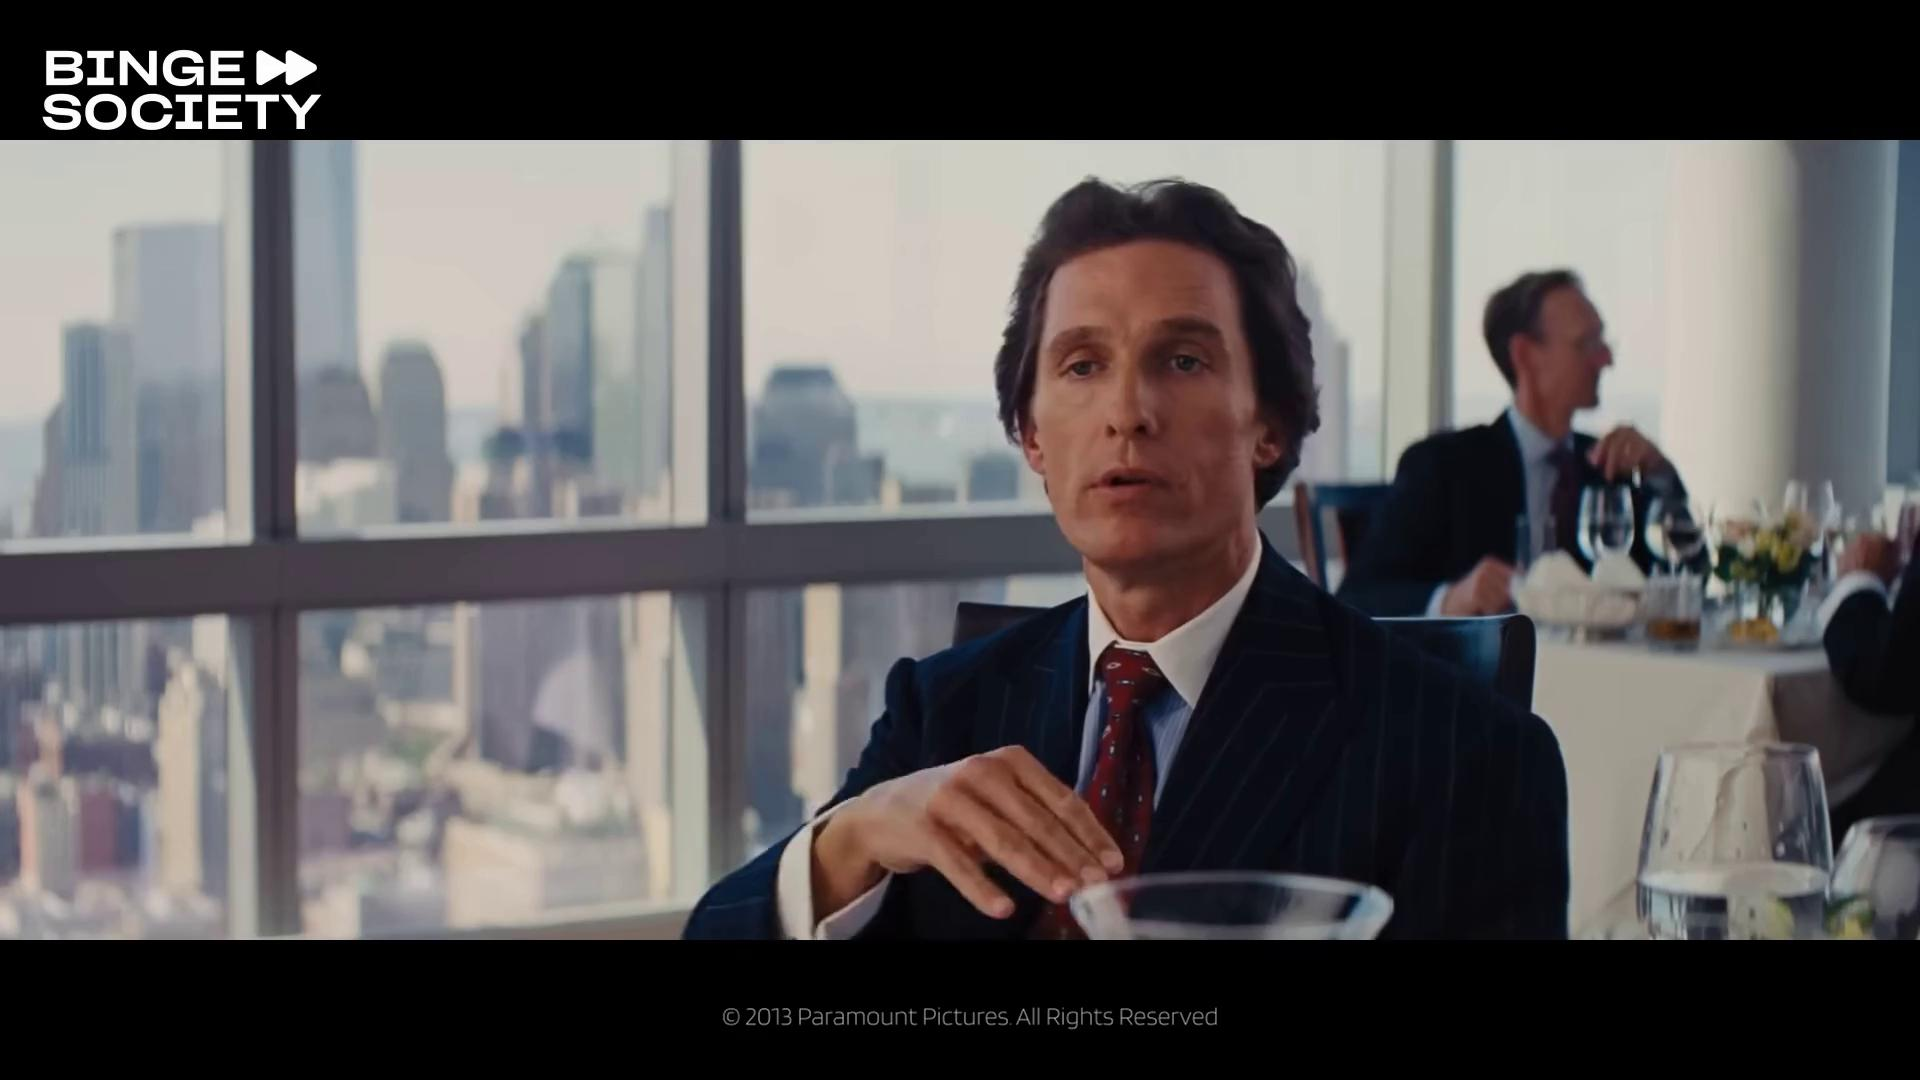

In [3]:
# @title Upload Pose reference Image

ref_uploaded = upload_file()
display_upload = True # @param {type:"boolean"}
if display_upload:
    if ref_uploaded.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=ref_uploaded))
    else:
        print("The image format cannot be displayed.")

In [2]:
# @title Repose Image

import time
start_time = time.time()

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

positive_prompt = "A man sitting on a chair in a hotel and trying to explain some thing" # @param {"type":"string"}
negative_prompt = "bad quality, blurry, messy, chaotic" # @param {"type":"string"}
# @markdown ---
# @markdown ### Image Settings
change_resolution=True # @param {type:"boolean"}
new_width = 448 # @param {"type":"number"}
new_height = 800 # @param {"type":"number"}
overwrite=True # @param {type:"boolean"}
# @markdown ---
# @markdown ### Sampler Settings
seed = 0 # @param {"type":"integer"}
steps = 6 # @param {"type":"integer", "min":1, "max":100}
cfg_scale = 5 # @param {"type":"number", "min":1, "max":20}
sampler_name="dpmpp_2m_sde_gpu" # @param ["uni_pc", "uni_pc_bh2", "ddim","euler", "euler_cfg_pp", "euler_ancestral", "euler_ancestral_cfg_pp", "heun", "heunpp2","dpm_2", "dpm_2_ancestral","lms", "dpm_fast", "dpm_adaptive", "dpmpp_2s_ancestral", "dpmpp_2s_ancestral_cfg_pp", "dpmpp_sde", "dpmpp_sde_gpu","dpmpp_2m", "dpmpp_2m_cfg_pp", "dpmpp_2m_sde", "dpmpp_2m_sde_gpu", "dpmpp_3m_sde", "dpmpp_3m_sde_gpu", "ddpm", "lcm","ipndm", "ipndm_v", "deis", "res_multistep", "res_multistep_cfg_pp", "res_multistep_ancestral", "res_multistep_ancestral_cfg_pp","gradient_estimation", "er_sde", "seeds_2", "seeds_3"]
scheduler="karras" # @param ["simple","normal","karras","exponential","sgm_uniform","ddim_uniform","beta","linear_quadratic","kl_optimal"]
# @markdown ---
# @markdown ### LoRA Settings
use_causvid_lora=True # @param {type:"boolean"}
causvid_lora_strength = 0.8 # @param {"type":"slider","min":-1,"max":1,"step":0.01}
# @markdown ---
# @markdown ### ControlNets Settings
use_canny=False # @param {type:"boolean"}
canny_low_threshold=100 # @param {"type":"slider","min":0,"max":255,"step":1}
canny_high_threshold=200 # @param {"type":"slider","min":0,"max":255,"step":1}
canny_resolution=512 # @param {"type":"slider","min":64,"max":16384,"step":64}
use_depth=True # @param {type:"boolean"}

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

# with torch.inference_mode():
generate_image(
    image_path=file_uploaded,
    ref_image_path=ref_uploaded,
    positive_prompt=positive_prompt,
    negative_prompt=negative_prompt,
    change_resolution=change_resolution,
    width=new_width,
    height=new_height,
    seed=seed,
    use_causvid=use_causvid_lora,
    causvid_lora_strength=causvid_lora_strength,
    steps=steps,
    cfg_scale=cfg_scale,
    sampler_name=sampler_name,
    scheduler=scheduler,
    match_colors=True,
    overwrite=overwrite,
    use_controlnet_canny=use_canny,
    low_threshold=canny_low_threshold,
    high_threshold=canny_high_threshold,
    resolution=canny_resolution,
    use_controlnet_depth=use_depth
)

end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"✅ Generation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()

NameError: name 'torch' is not defined